In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def fetch_index_data(index_ticker, period='5y'):
    """
    Fetch historical data for a given index ticker.
    
    :param index_ticker: Ticker symbol of the index
    :param period: Period for which to fetch the data (e.g., '5y' for 5 years)
    :return: DataFrame with historical index data
    """
    index = yf.Ticker(index_ticker)
    hist = index.history(period=period)
    return hist

In [3]:
def calculate_quarterly_returns(data):
    """
    Calculate quarterly returns from historical index data and format as percentages.
    
    :param data: DataFrame with historical index data (must contain 'Close' column)
    :return: DataFrame with quarterly returns in XX.XX% format
    """
    data.index = data.index.tz_localize(None)  # Remove timezone information
    data = data[data.index <= pd.Timestamp.today()]  # Ensure no future data
    data['Quarter'] = data.index.to_period('Q')
    quarterly_data = data.resample('QE-DEC').last()  
    quarterly_returns = quarterly_data['Close'].pct_change().dropna()
    
    # Convert returns to percentage format
    quarterly_returns = (quarterly_returns * 100).round(1).astype(str)
    
    return quarterly_returns

In [4]:
def generate_sector_returns():
    """
    Fetch and calculate quarterly returns for predefined sector indices.
    :return: DataFrame with quarterly returns for each sector
    """
    # Define sector indices 
    sector_indices = {
        'IT': '^CNXIT',
        'Metal': '^CNXMETAL',
        'Auto': '^CNXAUTO',
        'FMCG': '^CNXFMCG',
        'Energy': '^CNXENERGY',
        }
    
    sector_returns = {}
    
    for sector, index_ticker in sector_indices.items():
        index_data = fetch_index_data(index_ticker)
        quarterly_returns = calculate_quarterly_returns(index_data)
        sector_returns[sector] = quarterly_returns

    # Convert sector returns to a DataFrame
    df = pd.DataFrame(sector_returns)
    df =df.T
    return df

In [5]:
def export_to_csv(df, filename='sector_returns.csv'):
    """
    Export the DataFrame to a CSV file.
    """
    df.to_csv(filename)
    print(f"DataFrame exported to {filename}")

In [6]:
# Example usage
if __name__ == "__main__":
    # Generate sector returns and store in a DataFrame
    sector_returns_df = generate_sector_returns()
    
    # Export the DataFrame to a CSV file
    export_to_csv(sector_returns_df)

DataFrame exported to sector_returns.csv


In [7]:
Quarterly_returns_df = pd.read_csv('sector_returns.csv', index_col=0)

In [8]:
# Create DataFrame
Quilt_df = pd.DataFrame(Quarterly_returns_df) 

# Convert column names from string to datetime
Quilt_df.columns = pd.to_datetime(Quilt_df.columns, format='%Y-%m-%d')

# Convert datetime to quarter-year format with hyphen
Quilt_df.columns = Quilt_df.columns.to_period('Q').astype(str).str.replace('Q', '-Q')

Quilt_df =Quilt_df.T

# Reset the index to the default integer index
Quilt_df = Quilt_df.reset_index()

# Rename the 'index' column to 'Quarter'
Quilt_df = Quilt_df.rename(columns={'index': 'Quarter'})

In [9]:
# Create a matrix to store the ordered returns
quarters = Quilt_df['Quarter'].tolist()
sectors = list(Quilt_df.columns[1:])

# Generate a color palette
num_sectors = len(sectors)
cmap = plt.get_cmap('Accent', num_sectors)  # Use 'tab20' or any other suitable colormap
colors = [cmap(i) for i in range(num_sectors)]

# Create a color mapping for assets
sector_color_map = {sector: colors[i] for i, sector in enumerate(sectors)}

In [10]:
matrix = []
for quarter in quarters:
    quarterly_data = Quilt_df[['Quarter'] + sectors][Quilt_df['Quarter'] == quarter].T[1:]
    quarterly_data.columns = ['Return']
    quarterly_data = quarterly_data.sort_values(by='Return', ascending=False)
    matrix.append(quarterly_data.index.tolist())

# Set font properties
font_properties = {'fontname': 'DejaVu Sans', 'weight': 'bold', 'fontsize': 14}

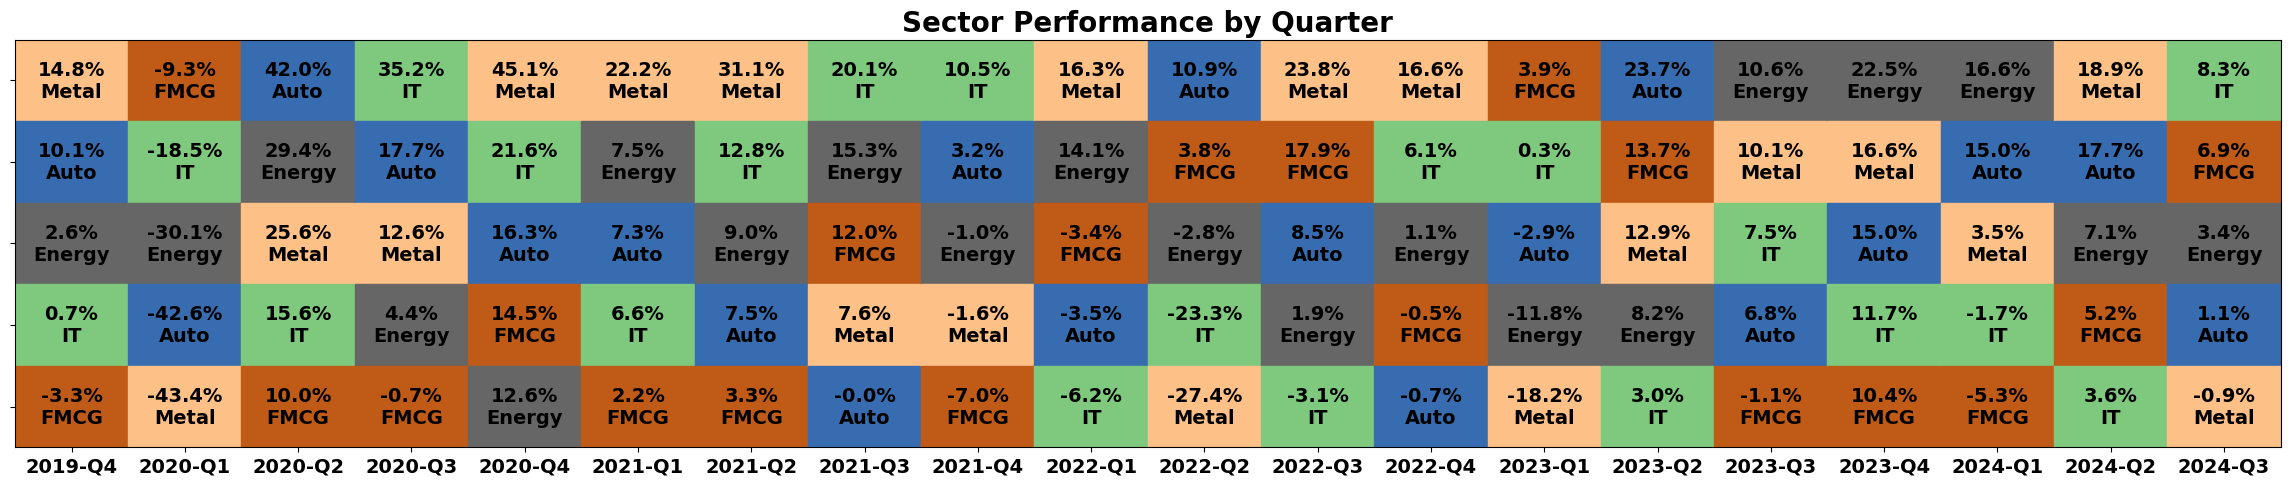

In [11]:
# Create the plot
fig, ax = plt.subplots(figsize=(len(quarters) * 1.2, len(sectors) *1.1))  # Adjust size dynamically

for i, quarter in enumerate(quarters):
    for j, sector in enumerate(matrix[i]):
        color = sector_color_map.get(sector, 'gray')
        value = Quilt_df[Quilt_df['Quarter'] == quarter][sector].values[0]
        ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color=color))
        ax.text(i + 0.5, j + 0.5, f"{value:.1f}%\n{sector}", ha='center', va='center', fontsize=14, clip_on=True, color='black', fontweight='bold', fontname='DejaVu Sans')

# Set the x and y axis labels
ax.set_xticks([i + 0.5 for i in range(len(quarters))])
ax.set_xticklabels(quarters, rotation=0, fontsize=14, fontweight='bold', fontname='DejaVu Sans')
ax.set_yticks([i + 0.5 for i in range(len(sectors))])
ax.set_yticklabels([])

# Add a title
plt.title('Sector Performance by Quarter', fontsize=20, fontweight='bold', fontname='DejaVu Sans')

# Adjust layout to avoid clipping
plt.tight_layout(pad=3.0)  # Increase padding to avoid clipping

# Adjust y-axis limits to ensure all patches are visible
ax.set_ylim(len(sectors), 0)  # Invert y-axis

# Adjust x-axis limits to ensure all patches are visible
ax.set_xlim(0, len(quarters))  # Set x-axis limits

# Save the plot as a high-resolution image
plt.savefig('sector_class_performance.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()